In [1]:
# загрузим библиотеки и установим опции

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:


# загрузим обучающую и тестовую выборки
train_df = pd.read_csv(r'C:\Users\User\Desktop\train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv(r'C:\Users\User\Desktop\test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()



,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"C:\Users\User\Desktop\site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'всего сайтов:', sites_dict.shape[0])
sites_dict.head()

всего сайтов: 48371


,site
13852,i1-js-14-3-01-11544-644949368-i.init.cedexis-r...
6240,static.vol24.fr
39840,mars.nasa.gov
3899,scholar.google.fr
9677,9zouxfza1h.s.ad6media.fr


In [4]:
train_df.shape

(253561, 21)

In [5]:
test_df.shape

(82797, 20)

In [6]:
# топ-сайты в обучающей выборке
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.ix[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


In [7]:
# топ-сайты в обучающей выборке
top_sites1 = pd.Series(train_df[train_df['target']==1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites1)
sites_dict.ix[top_sites1.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [8]:
# создадим отдельный датафрейм, где будем работать со временем
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# найдем время начала и окончания сессии
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# вычислим длительность сессии и переведем в секунды
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [9]:
time_df.shape

(253561, 4)

In [10]:
time_df[time_df['target']==0] ['seconds'].describe()

count    251264.000000
mean        139.282372
std         296.653518
min           0.000000
25%           7.000000
50%          28.000000
75%         114.000000
max        1800.000000
Name: seconds, dtype: float64

In [11]:
time_df.shape

(253561, 4)

In [12]:
251264/253561.0

0.9909410358848562

In [13]:
time_df[time_df['target']==0]

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0
242171,0,2013-01-12 08:50:22,2013-01-12 08:50:25,3.0
57157,0,2013-01-12 08:50:25,2013-01-12 08:50:28,3.0
240201,0,2013-01-12 08:50:28,2013-01-12 08:50:31,3.0
210686,0,2013-01-12 08:50:31,2013-01-12 08:50:36,5.0


In [14]:
time_df[(time_df['target']==1) & (time_df['seconds']>=40)] 

,target,min,max,seconds
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
76310,1,2013-02-12 16:35:50,2013-02-12 16:36:54,64.0
153722,1,2013-02-12 16:40:36,2013-02-12 16:43:20,164.0
78455,1,2013-02-12 16:43:31,2013-02-12 16:44:19,48.0
223688,1,2013-02-12 16:46:02,2013-02-12 16:46:44,42.0
1492,1,2013-02-12 16:46:46,2013-02-12 16:47:48,62.0
29720,1,2013-02-12 16:47:48,2013-02-12 16:48:47,59.0
12722,1,2013-02-12 16:49:34,2013-02-12 16:50:14,40.0


In [15]:
time_df[(time_df['target']==1)] 

,target,min,max,seconds
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0
167235,1,2013-02-12 16:33:55,2013-02-12 16:33:55,0.0
54979,1,2013-02-12 16:34:25,2013-02-12 16:34:40,15.0
77902,1,2013-02-12 16:34:40,2013-02-12 16:34:51,11.0
203387,1,2013-02-12 16:34:52,2013-02-12 16:35:27,35.0


In [16]:
554.0/2297

0.2411841532433609

In [17]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [18]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [19]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [20]:
full_sites.shape

(336358, 10)

In [21]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [22]:
full_sites.shape

(336358, 10)

In [23]:


# Сколько места занимает разреженная матрица в памяти?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# или сразу вот так:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))



1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


In [24]:


# данные, создаем список единичек, длина которого равна количеству элементов в исходной таблице (9)
# просуммировав количество единичек в ячейке получим частоту, 
# сколько было посещений определенного сайта за сессию
data = [1] * 9

# для этого надо правильно распределить единички по ячейкам
# индексы - номера сайтов, по ним будут суммироваться единички за сессии, т.е. колонки новой матрицы
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# индексы разбиения на строки (сессии)
# например, строка 0 это элементы между индексами [0; 3) - крайнее правое значение не включается
# строка 1 это элементы между индексами [3; 6) 
# строка 2 это элементы между индексами [6; 9) 
indptr = [0, 3, 6, 9]

# объединим эти три переменных в кортеж и сформируем матрицу
# чтобы вывести на экран преобразуем в обычную "плотную" матрицу
csr_matrix((data, indices, indptr)).todense()



matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

In [25]:
data

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
sites_flatten

array([  56,   55,    0, ..., 1098, 1098, 1098])

In [27]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # разделим выборку на обучающую и валидационную
    idx = int(round(X.shape[0] * ratio))
    # обучение классификатора
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # прогноз для валидационной выборки
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # считаем качество
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [28]:
%%time
# выделим из объединенной выборки только обучающую (для которой есть ответы)
X_train = full_sites_sparse[:idx_split, :]

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919524709674
Wall time: 15.4 s


In [29]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [30]:
# обучим модель на всей выборке
# random_state=17 для воспроизводимости
# параметр C=1 по умолчанию, но здесь мы его укажем явно
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_1.csv')

In [31]:
time_df

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0
242171,0,2013-01-12 08:50:22,2013-01-12 08:50:25,3.0
57157,0,2013-01-12 08:50:25,2013-01-12 08:50:28,3.0
240201,0,2013-01-12 08:50:28,2013-01-12 08:50:31,3.0
210686,0,2013-01-12 08:50:31,2013-01-12 08:50:36,5.0


In [32]:
# датафрейм для новых признаков
full_new_feat = pd.DataFrame(index=full_df.index)

# добавим признак start_month
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

In [33]:
full_df.shape

(336358, 20)

In [34]:
full_df_big = pd.concat([train_df, test_df])

In [35]:
full_df_big['target']

session_id
21669     0.0
54843     0.0
77292     0.0
114021    0.0
146670    0.0
242171    0.0
57157     0.0
240201    0.0
210686    0.0
98804     0.0
113494    0.0
223837    0.0
145475    0.0
186633    0.0
45193     0.0
102930    0.0
15789     0.0
205868    0.0
21102     0.0
193454    0.0
252924    0.0
12713     0.0
182016    0.0
55750     0.0
237109    0.0
120126    0.0
140105    0.0
129357    0.0
136699    0.0
113189    0.0
         ... 
82768     NaN
82769     NaN
82770     NaN
82771     NaN
82772     NaN
82773     NaN
82774     NaN
82775     NaN
82776     NaN
82777     NaN
82778     NaN
82779     NaN
82780     NaN
82781     NaN
82782     NaN
82783     NaN
82784     NaN
82785     NaN
82786     NaN
82787     NaN
82788     NaN
82789     NaN
82790     NaN
82791     NaN
82792     NaN
82793     NaN
82794     NaN
82795     NaN
82796     NaN
82797     NaN
Name: target, Length: 336358, dtype: float64

In [36]:
full_df_big['start_month']=full_new_feat['start_month']

In [37]:
ss=full_df_big[full_df_big['target']==1]['start_month'].value_counts().sort_index( ascending=[False])

In [38]:
full_df_big[full_df_big['target']==1]['start_month'].value_counts()

201311    446
201402    410
201403    400
201309    377
201404    302
201312    134
201401    129
201302     61
201304     38
Name: start_month, dtype: int64

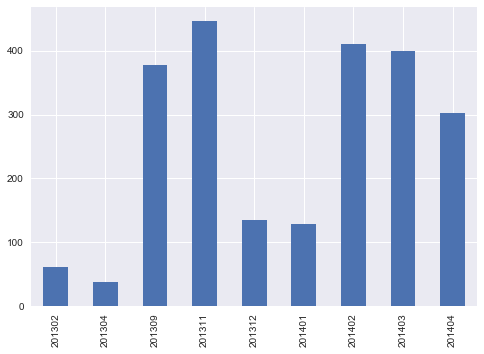

In [39]:
ss.plot(kind='bar')

In [40]:
# добавим новый признак в разреженную матрицу
tmp = full_new_feat[['start_month']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.750835486018


In [41]:
X_train

<253561x48372 sparse matrix of type '<type 'numpy.int64'>'
	with 1683237 stored elements in Compressed Sparse Row format>

In [42]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919698464197


In [44]:
full_sites.nunique(axis=1)

session_id
21669      3
54843      3
77292      6
114021     5
146670     6
242171     5
57157      5
240201     6
210686     5
98804      8
113494     4
223837     8
145475     5
186633     5
45193     10
102930     8
15789      8
205868     4
21102      6
193454     6
252924     6
12713      8
182016     8
55750      3
237109     7
120126     4
140105    10
129357     9
136699     4
113189     6
          ..
82768      6
82769      5
82770      2
82771      1
82772      8
82773      6
82774      9
82775      7
82776      7
82777      7
82778      7
82779      3
82780      5
82781      7
82782      7
82783      6
82784      2
82785      7
82786      3
82787      5
82788      5
82789      7
82790      9
82791      4
82792      8
82793      4
82794      6
82795     10
82796      7
82797      2
Length: 336358, dtype: int64

In [45]:
sss=full_sites.replace(0, np.NaN)

In [46]:
sss.nunique(axis=1)

session_id
21669      2
54843      2
77292      6
114021     5
146670     6
242171     5
57157      5
240201     6
210686     5
98804      8
113494     4
223837     8
145475     5
186633     5
45193     10
102930     8
15789      8
205868     3
21102      6
193454     6
252924     6
12713      8
182016     7
55750      2
237109     7
120126     4
140105    10
129357     9
136699     4
113189     6
          ..
82768      6
82769      4
82770      2
82771      1
82772      8
82773      6
82774      9
82775      7
82776      7
82777      7
82778      7
82779      3
82780      5
82781      7
82782      7
82783      6
82784      2
82785      7
82786      3
82787      5
82788      5
82789      7
82790      9
82791      4
82792      8
82793      3
82794      6
82795     10
82796      7
82797      2
Length: 336358, dtype: int64

In [47]:
sss

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54843,56,55.0,56.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN
77292,946,946.0,951.0,946.0,946.0,945.0,948.0,784.0,949.0,946.0
114021,945,948.0,949.0,948.0,945.0,946.0,947.0,945.0,946.0,946.0
146670,947,950.0,948.0,947.0,950.0,952.0,946.0,951.0,946.0,947.0
242171,952,947.0,953.0,946.0,947.0,946.0,953.0,955.0,946.0,947.0
57157,953,947.0,946.0,953.0,955.0,947.0,953.0,946.0,953.0,1033.0
240201,946,947.0,954.0,953.0,946.0,954.0,946.0,956.0,957.0,956.0
210686,946,956.0,946.0,946.0,955.0,954.0,946.0,946.0,946.0,948.0


In [48]:
# ваш код здесь
full_new_feat['n_unique_sites'] = sss.nunique(axis=1)

In [49]:
full_df_big['n_unique_sites']=full_new_feat['n_unique_sites'] 

In [50]:
full_df_big


,site1,site10,site2,site3,site4,site5,site6,site7,site8,site9,...,time2,time3,time4,time5,time6,time7,time8,time9,start_month,n_unique_sites
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,0,55,0,0,0,0,0,0,0,...,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,201301,2
54843,56,0,55,56,55,0,0,0,0,0,...,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,201301,2
77292,946,946,946,951,946,946,945,948,784,949,...,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,201301,6
114021,945,946,948,949,948,945,946,947,945,946,...,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,201301,5
146670,947,947,950,948,947,950,952,946,951,946,...,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,201301,6
242171,952,947,947,953,946,947,946,953,955,946,...,2013-01-12 08:50:23,2013-01-12 08:50:23,2013-01-12 08:50:23,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:24,2013-01-12 08:50:25,201301,5
57157,953,1033,947,946,953,955,947,953,946,953,...,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:26,2013-01-12 08:50:27,2013-01-12 08:50:27,2013-01-12 08:50:27,2013-01-12 08:50:28,201301,5
240201,946,956,947,954,953,946,954,946,956,957,...,2013-01-12 08:50:28,2013-01-12 08:50:28,2013-01-12 08:50:29,2013-01-12 08:50:29,2013-01-12 08:50:29,2013-01-12 08:50:30,2013-01-12 08:50:30,2013-01-12 08:50:31,201301,6
210686,946,948,956,946,946,955,954,946,946,946,...,2013-01-12 08:50:32,2013-01-12 08:50:32,2013-01-12 08:50:33,2013-01-12 08:50:33,2013-01-12 08:50:33,2013-01-12 08:50:34,2013-01-12 08:50:35,2013-01-12 08:50:36,201301,5


In [51]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.916185709317


In [52]:
full_df.shape

(336358, 20)

In [53]:
# ваш код здесь
#full_new_feat['start_hour'] = 
#full_new_feat['morning'] =
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts:  ts.hour)

In [55]:
full_new_feat['morning'] = full_df['time1'].apply(lambda ts:  (ts.hour >=11))

In [63]:

full_new_feat['morning']=full_new_feat['morning'].astype('int')

In [64]:
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301,2,8,0
54843,201301,2,8,0
77292,201301,6,8,0
114021,201301,5,8,0
146670,201301,6,8,0


In [65]:


# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))



0.956588013685


In [66]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))



0.9405835012


In [67]:
# добавим новый стандартизированный признак в разреженную матрицу
tmp = StandardScaler().fit_transform(full_new_feat[['morning','start_hour','start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.958543091725


In [68]:
# формируем обучающую выборку
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# зафиксируем качество с параметрами по умолчанию
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.958543393645


In [69]:
%%time
# набор возможных значений С
Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))



# установите и подключите этот модуль для отслеживания числа выполненных итераций 

# from tqdm import tqdm
# for C in tqdm(Cs):
#     scores.append(get_auc_lr_valid(X_train, y_train, C=C))

Wall time: 1min 57s


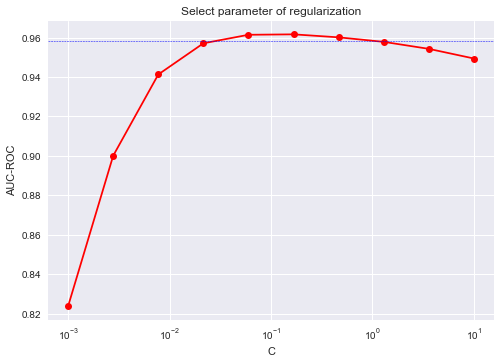

In [71]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Select parameter of regularization')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

In [72]:
Cs

array([  1.00000000e-03,   2.78255940e-03,   7.74263683e-03,
         2.15443469e-02,   5.99484250e-02,   1.66810054e-01,
         4.64158883e-01,   1.29154967e+00,   3.59381366e+00,
         1.00000000e+01])

In [73]:
C=0.17

In [74]:
# подготовим данные для обучения и теста
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_2.csv')

# PART 2

In [75]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [76]:
train_df = pd.read_csv(r'C:\Users\User\Desktop\mlcourse_open\data\howpop_train.csv')
test_df  = pd.read_csv(r'C:\Users\User\Desktop\mlcourse_open\data\howpop_test.csv')

In [77]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [78]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

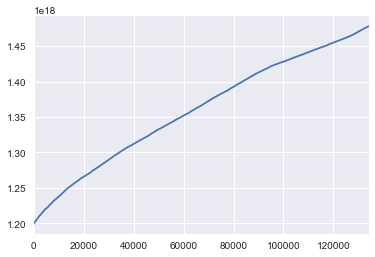

In [79]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

In [83]:
train_df.corr()

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [86]:
# датафрейм для новых признаков
train_new_feat = pd.DataFrame(index=train_df.index)
train_df['published']=train_df['published'].apply(pd.to_datetime)
# добавим признак 
train_new_feat['year']=train_df['published'].apply(lambda ts:  ts.year)

In [87]:
train_new_feat['year'].value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: year, dtype: int64

In [88]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [89]:


len(train_df),train_size



(134137, 93895)

In [90]:
X, y = train_df.ix[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.ix[:, features]

In [91]:


X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]



In [99]:
vectorizer_title = TfidfVectorizer(max_df=0.3, 
                                 min_df=3,  ngram_range=(1,3))#ваш код здесь

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title =  vectorizer_title.transform(X_test['title'])

In [97]:
vectorizer_title.vocabulary_['python']


9065

In [95]:
X_train_title.shape

(93895, 50624)

In [102]:
vectorizer_title_ch = TfidfVectorizer( analyzer='char')#ваш код здесь

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch=  vectorizer_title_ch.transform(X_test['title'])

In [103]:
X_train_title_ch.shape

(93895, 218)

In [104]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{u' ': 0,
 u'!': 1,
 u'"': 2,
 u'#': 3,
 u'$': 4,
 u'%': 5,
 u'&': 6,
 u"'": 7,
 u'(': 8,
 u')': 9,
 u'*': 10,
 u'+': 11,
 u',': 12,
 u'-': 13,
 u'.': 14,
 u'/': 15,
 u'0': 16,
 u'1': 17,
 u'2': 18,
 u'3': 19,
 u'4': 20,
 u'5': 21,
 u'6': 22,
 u'7': 23,
 u'8': 24,
 u'9': 25,
 u':': 26,
 u';': 27,
 u'<': 28,
 u'=': 29,
 u'>': 30,
 u'?': 31,
 u'@': 32,
 u'[': 33,
 u'\\': 34,
 u']': 35,
 u'^': 36,
 u'_': 37,
 u'`': 38,
 u'a': 39,
 u'b': 40,
 u'c': 41,
 u'd': 42,
 u'e': 43,
 u'f': 44,
 u'g': 45,
 u'h': 46,
 u'i': 47,
 u'j': 48,
 u'k': 49,
 u'l': 50,
 u'm': 51,
 u'n': 52,
 u'o': 53,
 u'p': 54,
 u'q': 55,
 u'r': 56,
 u's': 57,
 u't': 58,
 u'u': 59,
 u'v': 60,
 u'w': 61,
 u'x': 62,
 u'y': 63,
 u'z': 64,
 u'{': 65,
 u'|': 66,
 u'}': 67,
 u'~': 68,
 u'\x92': 69,
 u'\x97': 70,
 u'\xa0': 71,
 u'\xa3': 72,
 u'\xa5': 73,
 u'\xa7': 74,
 u'\xa9': 75,
 u'\xab': 76,
 u'\xad': 77,
 u'\xae': 78,
 u'\xb0': 79,
 u'\xb1': 80,
 u'\xb2': 81,
 u'\xb5': 82,
 u'\xb7': 83,
 u'\xb9': 84,
 u'\xbb': 85,
 u'\xbc': 86

In [105]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [106]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [107]:
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [108]:
X_train[feats][:5].fillna('-').T.to_dict().values()

[{'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}]

In [109]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<type 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [110]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]])

In [111]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

In [112]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [113]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

In [114]:
#В итоге получается разреженная матрица
vectorizer_feats = DictVectorizer()
X_train_feats = dict_vect.fit_transform(X_train[feats].fillna('-').T.to_dict().values())#...
X_valid_feats = dict_vect.transform(X_valid[feats].fillna('-').T.to_dict().values())#...#...
X_test_feats =dict_vect.transform(X_test[feats].fillna('-').T.to_dict().values())#... #...

In [115]:


X_train_feats.shape



(93895, 17869)

In [116]:


X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])



In [117]:
%%time
model1 = Ridge(alpha=1.0, random_state= 1)
model1.fit(X_train_new, y_train)#ваш код здесь
#здесь тоже ваш код



Wall time: 12.7 s


In [118]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.286243442812
Ошибка на тесте 0.806950087018


In [119]:

%%time
model2 = Ridge(alpha=0.1, random_state= 1)
model2.fit(X_train_new, y_train) #ваш код здесь
#здесь тоже ваш код



Wall time: 27.4 s


In [120]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.184104532793
Ошибка на тесте 0.996222642027


In [124]:
%%time
model = Ridge()#ваш код здесь
X_nn=scipy.sparse.vstack([X_train_new, X_valid_new])
model.fit(X_nn, y)

#обучите модель на всех данных

test_preds = model.predict(X_test_new)

Wall time: 20.5 s


In [126]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='url')

In [127]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [128]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
ridge_submission.to_csv('ridge_baseline.csv') #а вот и бейзлайн